# My Mobapp Studio

### <b>1.1 Importing necessary libraries</b>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### <b>1.2 Loading dataset</b>

In [ ]:
def load_dataset(file: str) -> pd.DataFrame:
  return pd.read_csv(file)

In [ ]:
df = load_dataset("/googleplaystore.csv")
df

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


### Summirizing dataset

In [ ]:
def print_summarize_dataset(dataset):
  print(f"""Dataset shape: {dataset.shape}\n
            First 10 rows of dataset: {dataset.head(10)}\n
            Dataset info: {dataset.info()}\n""")


In [ ]:
print_summarize_dataset(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
Dataset shape: (10841, 13)

            First 10 rows of dataset:                                                  App        Category  Rating  \
0     Photo Edito

In [ ]:
df.head(20)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [ ]:
def clean_dataset(dataset):

  dataset.dropna(inplace=True)

  dataset.dropna(subset = ['Rating'], inplace = True)
  dataset['Reviews'] = dataset['Reviews'].astype(int)
  dataset['Type'] = dataset['Type'].str.replace('Free', '1').str.replace('Paid', '0').astype(int)
  dataset['Price'] = dataset['Price'].str.replace('$', '').astype(float)
  dataset['Installs'] = dataset['Installs'].str.replace(r',|\+', '', regex = True).astype(int)

  return dataset

In [ ]:
clean_dataset(df)

<ipython-input-19-83443dd31fd9>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset['Price'] = dataset['Price'].str.replace('$', '').astype(float)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,1,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,1,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,1,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,1,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,1,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834,FR Calculator,FAMILY,4.0,7,2.6M,500,1,0.0,Everyone,Education,"June 18, 2017",1.0.0,4.1 and up
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,5000,1,0.0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100,1,0.0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,1000,1,0.0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


In [ ]:
df.describe()

,Rating,Reviews,Installs,Type,Price
count,9360.000000,9.360000e+03,9.360000e+03,9360.000000,9360.000000
mean,4.191838,5.143767e+05,1.790875e+07,0.931090,0.961279
std,0.515263,3.145023e+06,9.126637e+07,0.253315,15.821640
min,1.000000,1.000000e+00,1.000000e+00,0.000000,0.000000
25%,4.000000,1.867500e+02,1.000000e+04,1.000000,0.000000
50%,4.300000,5.955000e+03,5.000000e+05,1.000000,0.000000
75%,4.500000,8.162750e+04,5.000000e+06,1.000000,0.000000
max,5.000000,7.815831e+07,1.000000e+09,1.000000,400.000000


In [ ]:
def print_histograms(dataset):
    dataset.hist(column = ['Rating', 'Reviews', 'Type', 'Price', 'Installs'], bins = 20, figsize=(15, 15))
    plt.show()

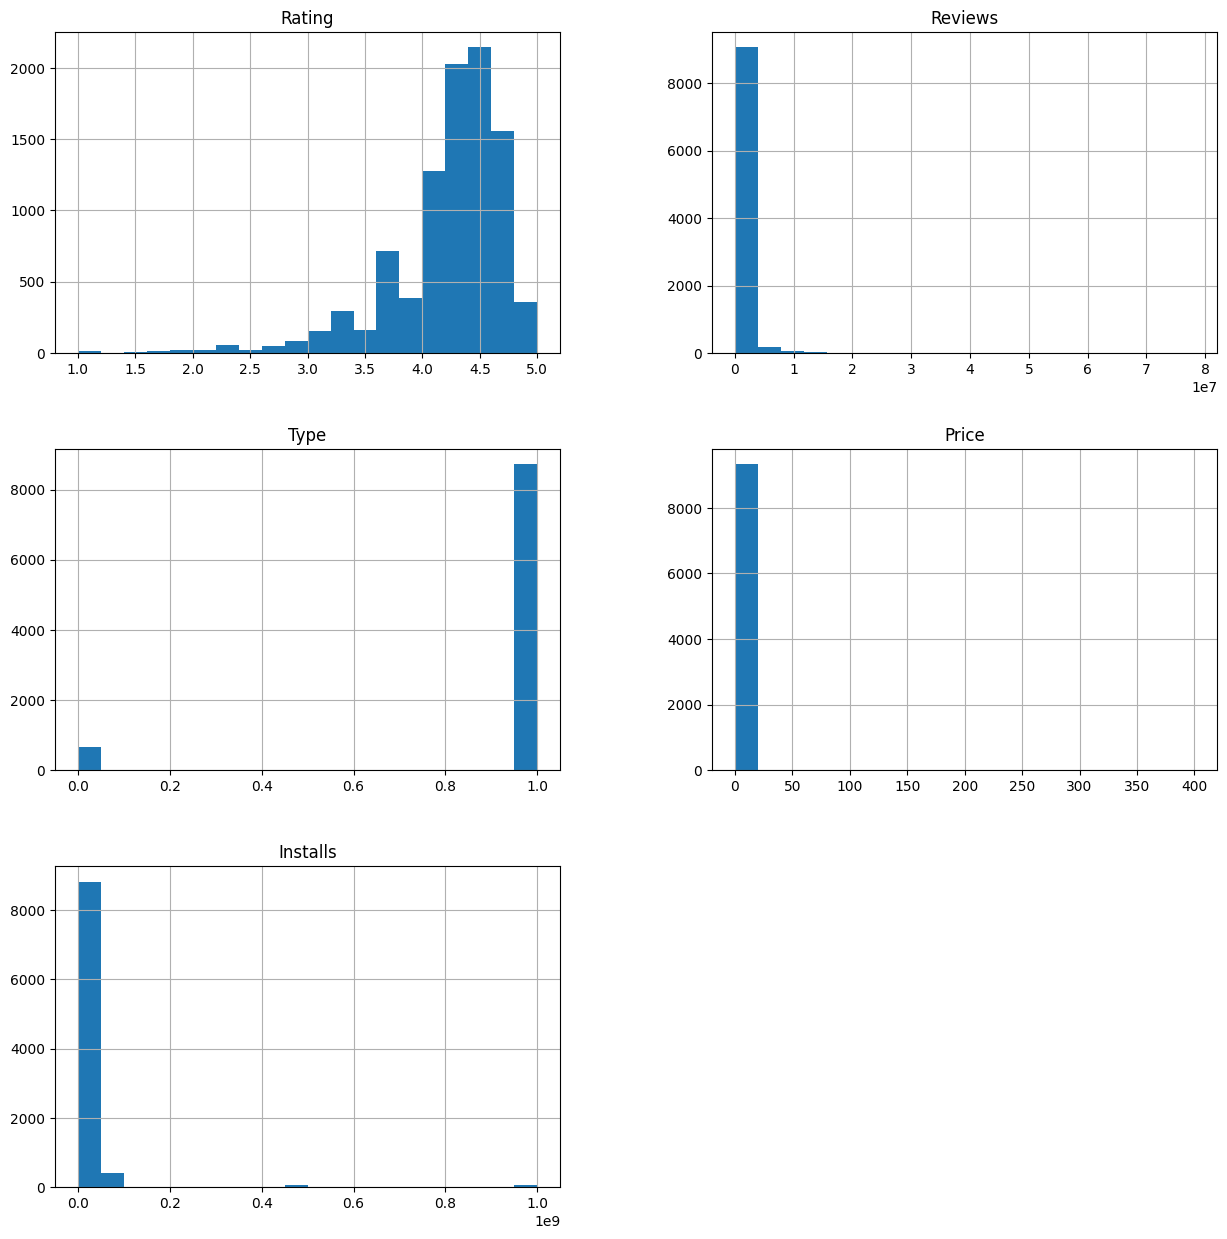

In [ ]:
print_histograms(df)

In [ ]:
def compute_correlations_matrix(dataset):
    # Assuming 'dataset' is a Pandas DataFrame
    correlation_matrix = dataset.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

<ipython-input-24-fea5052c9f9e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dataset.corr()


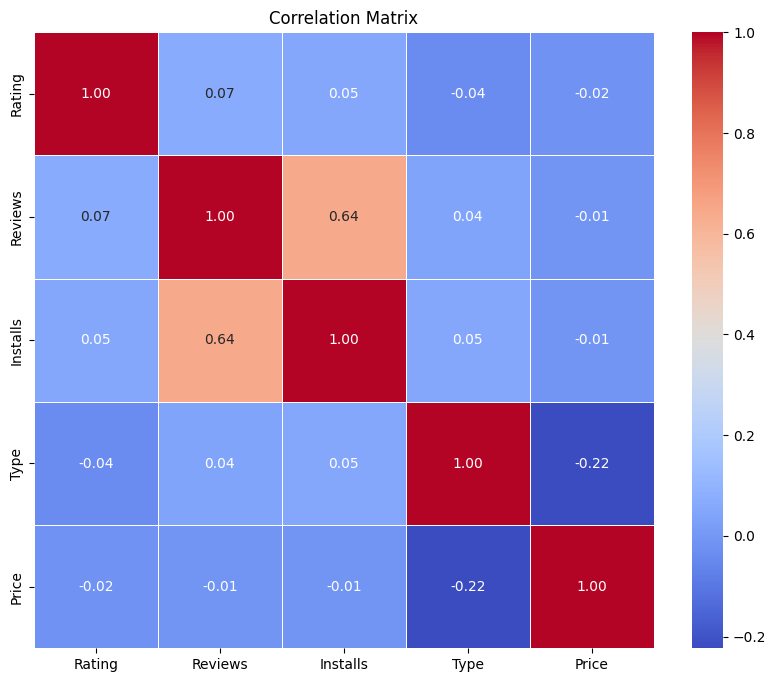

In [ ]:
compute_correlations_matrix(df)

In [ ]:
def print_scatter_matrix():
  sns.pairplot(df)
  plt.show()

In [ ]:
print_scatter_matrix()

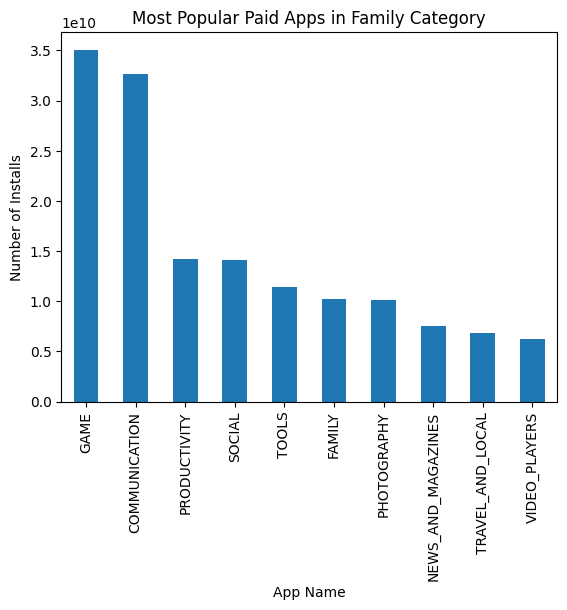

In [30]:
df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Most Popular Paid Apps in Family Category')
plt.xlabel('App Name')
plt.ylabel('Number of Installs')
plt.show()


<Axes: ylabel='Installs'>

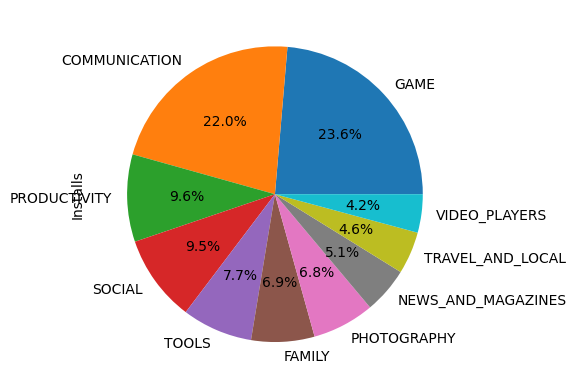

In [31]:
df.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.1f%%')